In [352]:
import pandas as pd
from pathlib import Path 

In [353]:
tables_path = Path('data', 'tables')
df = pd.read_csv(tables_path / 'merged_award_show_winners.csv', keep_default_na=False, na_values=[''])
df.head()

,Show,Date,Artist,Song,Total,Winner,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo
0,M Countdown,2022-10-27,(G)I-dle,Nxde,0,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0
1,Show! Music Core,2023-06-10,(G)I-dle,Queencard,6460,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
2,Show! Music Core,2023-06-03,(G)I-dle,Queencard,8133,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
3,Inkigayo,2023-06-04,(G)I-dle,Queencard,9423,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
4,Show Champion,2022-11-09,(G)I-dle,Nxde,5435,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0


In [354]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Show                    1142 non-null   object        
 1   Date                    1142 non-null   datetime64[ns]
 2   Artist                  1142 non-null   object        
 3   Song                    1142 non-null   object        
 4   Total                   1142 non-null   int64         
 5   Winner                  1142 non-null   int64         
 6   file_path               1142 non-null   object        
 7   vggish_dance            1142 non-null   float64       
 8   vggish_party            1142 non-null   float64       
 9   vggish_happy            1142 non-null   float64       
 10  vggish_sad              1142 non-null   float64       
 11  effnet_party            1142 non-null   float64       
 12  effnet_happy            1142 non-null   float64 

### Minor Processing

I noticed that there were some inconsistencies with the naming conventions for the artist column, so I going back to match any artist that conflict with their winning artist naming convention (if that artist has won before, otherwise do not change)

In [355]:
import pandas as pd
from thefuzz import process

def fuzzy_match_artists(non_winners, df_full, artist_col="Artist", score_cutoff=85):
    full_artist_list = df_full[artist_col].dropna().unique().tolist()
    results = []

    for artist in non_winners:
        match_result = process.extractOne(artist, full_artist_list, score_cutoff=score_cutoff)

        if match_result is not None:
            match, score = match_result
            results.append({
                "original_artist": artist,
                "matched_artist": match,
                "match_score": score
            })
        else:
            results.append({
                "original_artist": artist,
                "matched_artist": None,
                "match_score": None
            })

    return pd.DataFrame(results)


In [356]:
non_winners = most_wins[most_wins.values == 0].keys().tolist()
winners = df.copy()[~df.Artist.isin(non_winners)]

matches = fuzzy_match_artists(non_winners, winners, score_cutoff=92)
match_dict = dict(zip(matches['original_artist'], matches['matched_artist']))

display(matches[~matches['match_score'].isna()].sort_values(by=['match_score', 'original_artist'], ascending=[False, True]))

,original_artist,matched_artist,match_score
50,(G)I-DLE,(G)I-dle,100.0
41,BABYMONSTER,BabyMonster,100.0
15,DAY6,Day6,100.0
81,ENHYPEN,Enhypen,100.0
83,EVERGLOW,Everglow,100.0
85,EVNNE,Evnne,100.0
65,EXO,Exo,100.0
95,ILLIT,Illit,100.0
52,ITZY,Itzy,100.0
53,IVE,Ive,100.0


In [357]:
df['Artist'] = df['Artist'].map(match_dict).combine_first(df["Artist"])

One last inconsistency that wasn't found via fuzzy matching was that Hwang Karam's name was misspelled for an entry.

In [358]:
df.loc[df.Artist == 'Hwang Kagam', 'Artist'] = 'Hwang Karam'
df.loc[df.Artist == '(G)I-DLE', 'Artist'] = '(G)I-dle'
df.head()

,Show,Date,Artist,Song,Total,Winner,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo
0,M Countdown,2022-10-27,(G)I-dle,Nxde,0,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0
1,Show! Music Core,2023-06-10,(G)I-dle,Queencard,6460,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
2,Show! Music Core,2023-06-03,(G)I-dle,Queencard,8133,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
3,Inkigayo,2023-06-04,(G)I-dle,Queencard,9423,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
4,Show Champion,2022-11-09,(G)I-dle,Nxde,5435,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0


## Initial Inspections

In this section, I want to explore some basic insights found within the data such as what group has the most wins, who is always on the cusp of achieving their first win, and the trends within the total amount of votes observed within certain time periods. Most of this analysis will likely pertain to the first 6 columns: `Show`, `Date`, `Artist`, `Song`, `Total`, and `Winner`

In [359]:
most_wins = df.groupby('Artist')['Winner'].sum().sort_values(ascending=False)
display(most_wins[:10])

Artist
Ive            64
(G)I-dle       42
NewJeans       35
Le Sserafim    34
Aespa          27
Stray Kids     26
Seventeen      26
NCT Dream      23
Ateez          19
Jung Kook      18
Name: Winner, dtype: int64

In [360]:
never_won = most_wins[most_wins.values == 0].keys()
never_won

Index(['xikers', 'A.C.E', 'ALL(H)OURS', 'ARrC', 'ATBO', 'YOUNG POSSE',
       'DAVICHI', 'BamBam', 'Tzuyu', 'UNIS', 'BBGIRLS', 'BIGNaughty', 'BOL4',
       'WENDY', 'Lee Jegyu', 'Lim Jae-hyun', 'NouerA', 'Odd Eye Circle',
       'Kim Sejeong', 'LAPILLUS', 'LUN8', 'Kassy', 'KickFlip', 'Kim Hee-Jae',
       'Parc Jae-jung', 'Jukjae', 'JxW', 'KARD', 'KUN8', 'JD1', 'RESCENE',
       'ROSÉ', 'SAY MY NAME', 'SOMI', 'Infinite', 'JAESSBEE', 'Secret Number',
       'Sung Si-Kyung, Naul', 'THE NEW SIX', 'HUI', 'HWASA', 'Hwang Karam',
       'IRENE', 'TIOT', 'TONY', 'TRI.BE', 'GENBLUE', 'GOT7', 'Golden Child',
       'GroovyRoom', 'HORI7ON', 'HOSHI X WOOZI', 'FANTASY BOYS', 'FIFTY FIFTY',
       'Taeyoung', 'Tophyun', 'DRIPPIN', 'DXMON', 'EPEX', 'CHUU', 'CIX', 'D.O',
       'WEi', 'Woody', 'XG', 'Xdinary Heroes', '8TURN', 'ZiA', '82MAJOR',
       'YOUNITE', 'YUQI', 'ZOZAZZ', 'NEXZ', 'NOWADAYS', 'MEOVV', 'MIRAE',
       'Moon Byul', 'Lee Chae-yeon'],
      dtype='object', name='Artist')

So far, we have a great understanding of which artists are highly decorated in music show wins and artists that have yet achieved their coveted win. In terms of artists with the most wins, there are no surprises as this list is dominated by the most popular 4th generation BGs and GGs. For artists that haven't won, we can observe several 5th generation groups such as YOUNG POSSE, RESCENE, MEOWV whom are barely starting their careers in KPOP so there is definitely potential for them to find a win within the coming years. Additionally, we can observe that it's a bit of a struggle for solo artists to obtain a win. With the exception of ROSÉ because she won with APT with Bruno Mars, winning at a music show can be difficult despite an idol's popularity. For example, veterans such as Wendy, Lee Chae-yeon, and Tzuyu are well-known female idols that come from very popular groups (Red Velvet, ex-Izone, Twice respectively) but haven't been able to acquire awards. Next, I want to observe music show wins on a monthly basis

In [361]:
df

,Show,Date,Artist,Song,Total,Winner,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo
0,M Countdown,2022-10-27,(G)I-dle,Nxde,0,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0
1,Show! Music Core,2023-06-10,(G)I-dle,Queencard,6460,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
2,Show! Music Core,2023-06-03,(G)I-dle,Queencard,8133,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
3,Inkigayo,2023-06-04,(G)I-dle,Queencard,9423,1,data/audio/queencard_(g)i-dle.flac,92.974657,14.019252,81.471860,88.088149,1.055119,87.547588,94.290292,80.357134,98.429692,48.345432,130.0
4,Show Champion,2022-11-09,(G)I-dle,Nxde,5435,1,data/audio/nxde_(g)i-dle.flac,91.352266,20.125487,73.873174,82.415563,9.883992,65.411216,90.908891,73.706400,94.578671,50.409603,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,The Show,2024-03-19,xikers,We Don't Stop,2507,0,data/audio/we_don't_stop_xikers.flac,91.866928,14.823136,62.313324,88.575870,4.802846,50.686002,94.867623,72.911227,97.337955,46.941653,104.0
1138,The Show,2023-08-29,xikers,HOMEBOY,2932,0,data/audio/homeboy_xikers.flac,93.750942,16.895656,68.301415,71.766502,6.488638,59.391260,89.845961,80.581129,95.526505,50.632000,138.0
1139,The Show,2023-08-08,xikers,DO or DIE,5693,0,data/audio/do_or_die_xikers.flac,76.148283,23.598190,62.018633,93.452352,5.584002,80.498070,96.787137,75.473613,99.064237,46.210933,169.0
1140,Show Champion,2025-04-09,xikers,BREATHE,2803,0,data/audio/breathe_xikers.flac,85.196966,29.395086,51.734620,77.542847,20.699333,46.466920,89.911395,57.283974,93.417108,48.471853,155.0


In [362]:
# Track the cumulative wins for a given group
df = df.sort_values(by='Date').reset_index(drop=True)
df['cumulative_wins'] = df.groupby('Artist')['Winner'].cumsum()
df

,Show,Date,Artist,Song,Total,Winner,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo,cumulative_wins
0,Music Bank,2022-01-07,NCT U,Universe,5930,1,data/audio/universe_nct_u.flac,91.257358,24.276087,68.799776,75.639653,2.052916,48.983282,92.630267,85.705370,96.708155,50.742459,90.0,1
1,Show! Music Core,2022-01-08,Ive,Eleven,6408,1,data/audio/eleven_ive.flac,94.969267,14.487194,81.253165,86.618441,2.624009,44.949305,88.751704,91.412026,92.126274,51.922560,120.0,1
2,Inkigayo,2022-01-09,Ive,Eleven,8533,1,data/audio/eleven_ive.flac,94.969267,14.487194,81.253165,86.618441,2.624009,44.949305,88.751704,91.412026,92.126274,51.922560,120.0,2
3,M Countdown,2022-01-13,Kep1er,Wa Da Da,6500,1,data/audio/wa_da_da_kep1er.flac,96.806079,8.892117,78.541529,93.299967,1.427768,66.829628,95.882148,71.224576,97.788805,49.050409,126.0,1
4,Music Bank,2022-01-14,Kep1er,Wa Da Da,3678,1,data/audio/wa_da_da_kep1er.flac,96.806079,8.892117,78.541529,93.299967,1.427768,66.829628,95.882148,71.224576,97.788805,49.050409,126.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,Show Champion,2025-04-16,Mark,1999,5592,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,1
1138,M Countdown,2025-04-17,J-Hope,Mona Lisa,7643,1,data/audio/mona_lisa_j-hope.flac,97.054577,17.678125,60.819304,67.917317,10.585602,39.631873,87.287062,87.912464,92.784697,45.539203,138.0,2
1139,Music Bank,2025-04-18,Mark,1999,9606,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,2
1140,Show! Music Core,2025-04-19,Mark,1999,7159,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,3


In [363]:
most_wins[:15]

Artist
Ive            64
(G)I-dle       42
NewJeans       35
Le Sserafim    34
Aespa          27
Stray Kids     26
Seventeen      26
NCT Dream      23
Ateez          19
Jung Kook      18
STAYC          18
Blackpink      17
G-Dragon       16
The Boyz       15
Zerobaseone    15
Name: Winner, dtype: int64

In [364]:
# Gather the top 5 Artists relative to wins
top_5 = df.loc[df.Artist.isin(most_wins.keys()[:5])]
top_5_artists = top_5.Artist.unique()
first_wins = top_5.groupby(['Artist', 'Song'])['Date'].min().to_dict()

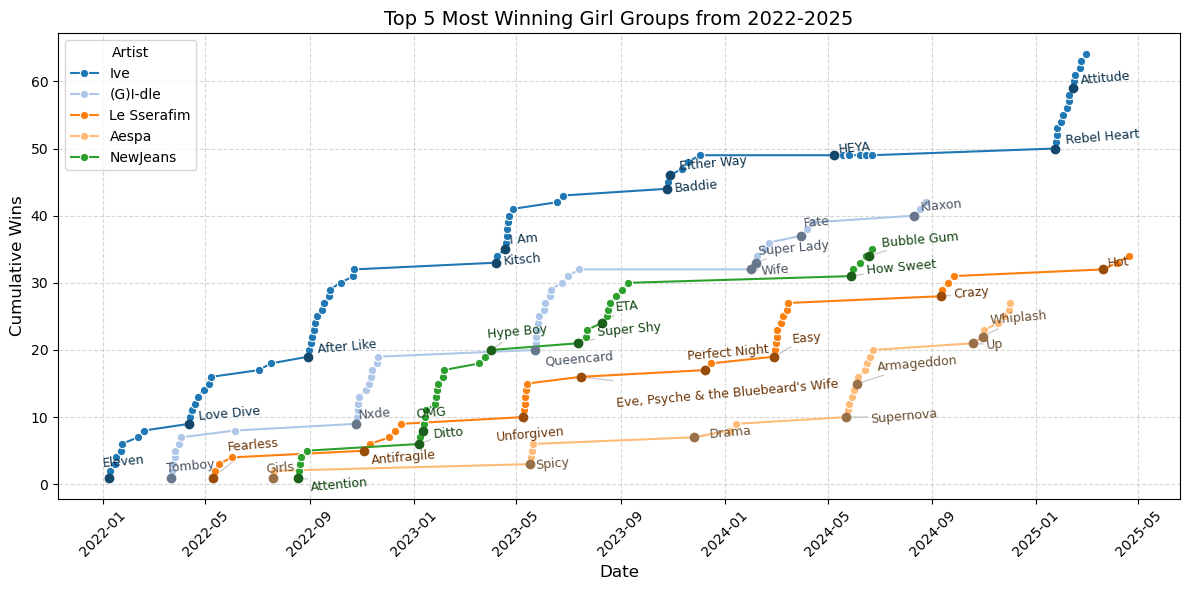

In [365]:
import seaborn as sns
from adjustText import adjust_text

def darken(color, factor=0.6):
    return tuple([max(0, min(1, c*factor)) for c in color])

plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab20", n_colors=5)
artist_colors = dict(zip(top_5_artists, palette))

sns.lineplot(data=top_5, x='Date', y='cumulative_wins', hue='Artist', marker='o', palette=artist_colors)

texts = []
for (artist, song), win_date in first_wins.items():
    song_data = top_5[(top_5['Artist'] == artist) & (top_5['Date'] == win_date)]
    win_score = song_data['cumulative_wins'].values[0]
    song = song_data['Song'].values[0]
    darker_color = darken(artist_colors[artist], 0.6)

    plt.scatter(win_date, win_score, color=darker_color, zorder=5)
    texts.append(plt.text(win_date, win_score, f"{song}", fontsize=9, rotation=5, color=darken(darker_color, .7), zorder=6))

adjust_text(texts, only_move={'text': 'xy'}, 
            arrowprops=dict(arrowstyle="-", color='gray', alpha=0.4)
            )

plt.xticks(rotation=45)

plt.title("Top 5 Most Winning Girl Groups from 2022-2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Wins", fontsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [366]:
df_song = df.copy()
df_song['cumulative_song_wins'] = df_song.groupby(['Artist', 'Song'])['Winner'].cumsum()
df_song.tail(10)

,Show,Date,Artist,Song,Total,Winner,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo,cumulative_wins,cumulative_song_wins
1132,Show Champion,2025-04-09,xikers,BREATHE,2803,0,data/audio/breathe_xikers.flac,85.196966,29.395086,51.734620,77.542847,20.699333,46.466920,89.911395,57.283974,93.417108,48.471853,155.0,0,0
1133,M Countdown,2025-04-10,J-Hope,Mona Lisa,7638,1,data/audio/mona_lisa_j-hope.flac,97.054577,17.678125,60.819304,67.917317,10.585602,39.631873,87.287062,87.912464,92.784697,45.539203,138.0,1,1
1134,Music Bank,2025-04-11,Close Your Eyes,All My Poetry,5507,1,data/audio/all_my_poetry_close_your_eyes.flac,94.772673,39.468187,58.600849,39.521444,25.972188,28.459117,65.364033,94.837797,89.037490,52.617425,89.0,2,2
1135,Show! Music Core,2025-04-12,Jennie,Like Jennie,6095,1,data/audio/like_jennie_jennie.flac,96.556515,10.664071,75.223869,90.521652,1.441297,64.432132,94.390357,60.059088,98.381501,45.949566,130.0,6,5
1136,The Show,2025-04-15,Izna,Sign,8450,1,data/audio/sign_izna.flac,88.072568,29.451549,68.790400,65.389323,9.329961,47.375980,81.288213,86.777866,92.014247,50.026554,125.0,1,1
1137,Show Champion,2025-04-16,Mark,1999,5592,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,1,1
1138,M Countdown,2025-04-17,J-Hope,Mona Lisa,7643,1,data/audio/mona_lisa_j-hope.flac,97.054577,17.678125,60.819304,67.917317,10.585602,39.631873,87.287062,87.912464,92.784697,45.539203,138.0,2,2
1139,Music Bank,2025-04-18,Mark,1999,9606,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,2,2
1140,Show! Music Core,2025-04-19,Mark,1999,7159,1,data/audio/1999_mark.flac,89.464378,20.914400,68.907583,79.903740,11.274675,38.706461,84.773290,84.185988,93.693328,50.857013,109.0,3,3
1141,Inkigayo,2025-04-20,Le Sserafim,Hot,4556,1,data/audio/hot_le_sserafim.flac,85.022485,36.216292,74.394268,59.621853,4.694841,70.224762,91.213101,75.978297,93.216521,47.584522,128.0,34,3


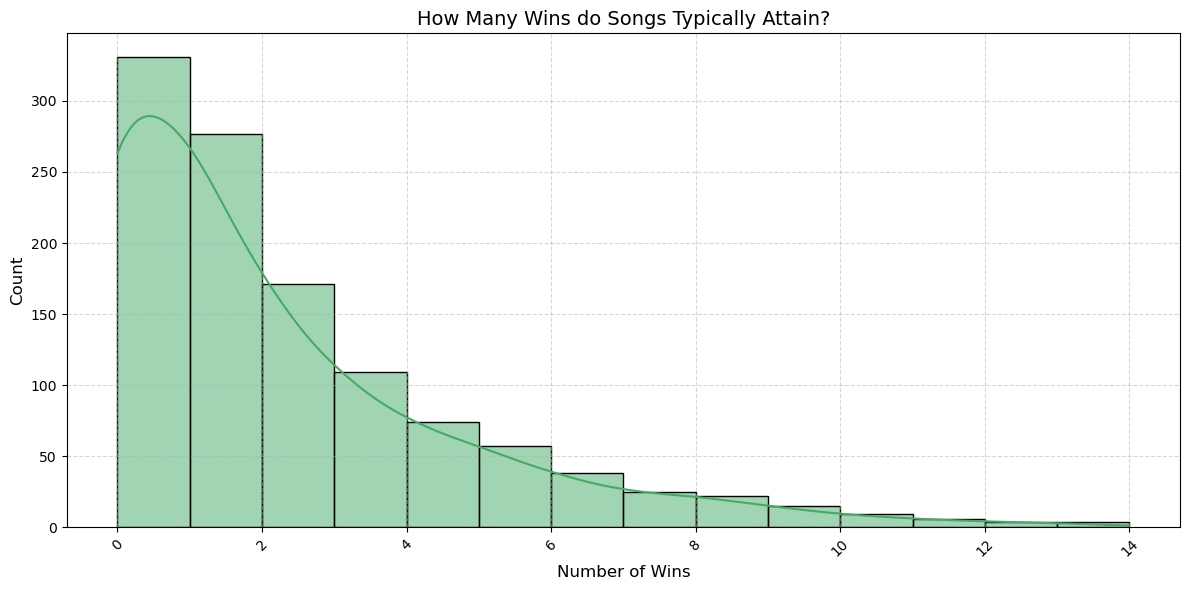

In [367]:
plt.figure(figsize=(12,6))

sns.histplot(data=df_song, x="cumulative_song_wins", stat='count', binwidth=1, kde=True, color="#44AA66")

plt.xticks(rotation=45)

plt.title("How Many Wins do Songs Typically Attain?", fontsize=14)
plt.xlabel("Number of Wins", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [368]:
df_song.groupby(['Artist', 'Song']).max()

Show       Date  Total  Winner  \
Artist   Song                                                     
(G)I-dle Fate                Inkigayo 2024-04-14   6119       1   
         Klaxon              Inkigayo 2024-08-25   6883       1   
         Nxde                The Show 2022-11-20  12541       1   
         Queencard           The Show 2023-07-14  10487       1   
         Super Lady     Show Champion 2024-02-22   8780       1   
...                               ...        ...    ...     ...   
xikers   BREATHE             The Show 2025-04-09   3245       0   
         Bittersweet         The Show 2024-09-24   3990       0   
         DO or DIE           The Show 2023-08-09   5693       0   
         HOMEBOY             The Show 2023-08-29   2932       0   
         We Don't Stop       The Show 2024-03-20   2860       0   

                                                   file_path  vggish_dance  \
Artist   Song                                                                
(G)I-dle Fate                  data/audio/fate_(g)i-dle.flac     84.896851   
         Klaxon              data/audio/klaxon_(g)i-dle.flac     94.968563   
         Nxde                  data/audio/nxde_(g)i-dle.flac     91.352266   
         Queencard        data/audio/queencard_(g)i-dle.flac     92.974657   
         Super Lady      data/audio/super_lady_(g)i-dle.flac     93.853968   
...                                                      ...           ...   
xikers   BREATHE              data/audio/breathe_xikers.flac     85.196966   
         Bittersweet      data/audio/bittersweet_xikers.flac     94.634980   
         DO or DIE          data/audio/do_or_die_xikers.flac     76.148283   
         HOMEBOY              data/audio/homeboy_xikers.flac     93.750942   
         We Don't Stop  data/audio/we_don't_stop_xikers.flac     91.866928   

                        vggish_party  vggish_happy  vggish_sad  effnet_party  \
Artist   Song                                                                  
(G)I-dle Fate              34.739900     81.303555   75.299674      9.358480   
         Klaxon            12.903826     85.615748   88.195956      1.819369   
         Nxde              20.125487     73.873174   82.415563      9.883992   
         Queencard         14.019252     81.471860   88.088149      1.055119   
         Super Lady        11.460950     79.334939   90.879261      3.159332   
...                              ...           ...         ...           ...   
xikers   BREATHE           29.395086     51.734620   77.542847     20.699333   
         Bittersweet       14.152902     69.460541   83.893681     10.475194   
         DO or DIE         23.598190     62.018633   93.452352      5.584002   
         HOMEBOY           16.895656     68.301415   71.766502      6.488638   
         We Don't Stop     14.823136     62.313324   88.575870      4.802846   

                        effnet_happy  effnet_sad  effnet_approachability  \
Artist   Song                                                              
(G)I-dle Fate              57.874048   78.738225               93.074292   
         Klaxon            89.400703   96.012336               89.402223   
         Nxde              65.411216   90.908891               73.706400   
         Queencard         87.547588   94.290292               80.357134   
         Super Lady        58.018756   90.698040               83.888447   
...                              ...         ...                     ...   
xikers   BREATHE           46.466920   89.911395               57.283974   
         Bittersweet       43.760720   86.478573               76.828885   
         DO or DIE         80.498070   96.787137               75.473613   
         HOMEBOY           59.391260   89.845961               80.581129   
         We Don't Stop     50.686002   94.867623               72.911227   

                        effnet_engagement  effnet_timbre_bright  tempo  \
Artist   Song                             